In [9]:
#import packages internal and external
import tests
import numpy as np
import warnings
warnings.filterwarnings('ignore')
from importlib import reload
import pandas as pd
import datasetBuilder
import tools
import scipy
from sklearn.ensemble import HistGradientBoostingClassifier as hgbc
from sklearn.ensemble import GradientBoostingClassifier as gbc
from sklearn.ensemble import RandomForestClassifier as rfc
import sklearn.base
import pickle
import copy
import tests
from sklearn.metrics import roc_auc_score as auc
import os
import plotAndOrderResults
import datasetBuilder
from collections import Counter

In [2]:
#Set path variables where we want to save created datasets, intermediate outputs, etc
#If you want to run this on your own computer, obviously you should update the path

outputs_path='/Users/jonahpoczobutt/projects/specsim_res/nist_23_self'
os.mkdir(outputs_path)


nist14='/Users/jonahpoczobutt/projects/raw_data/db_csvs/nist14_highres.pkl'
nist23_hr_base = '/Users/jonahpoczobutt/projects/raw_data/db_csvs/nist23_base.pkl'
nist_23_hr_full ='/Users/jonahpoczobutt/projects/raw_data/db_csvs/nist23_full.pkl'
gnps='/Users/jonahpoczobutt/projects/raw_data/db_csvs/gnps_highres.pkl'
mona='/Users/jonahpoczobutt/projects/raw_data/db_csvs/mona_highres.pkl'
metlin='/Users/jonahpoczobutt/projects/raw_data/db_csvs/metlin_highres_inst.pkl'
mona_nist = '/Users/jonahpoczobutt/projects/raw_data/db_csvs/mona_nist_prot_only.pkl'

#Set the query and target dbs
#these can be different or the same
query = nist23_hr_base
target = nist23_hr_base

#This variable toggles whether we do a full run of the notebook, or if we read in variables created in a previous run
fullRun=True

#create directories for results
if fullRun:
    
    os.mkdir(f'{outputs_path}/intermediateOutputs')
    os.mkdir(f'{outputs_path}/intermediateOutputs/fullSearchMatches')
    os.mkdir(f'{outputs_path}/intermediateOutputs/splitMatches')
    os.mkdir(f'{outputs_path}/intermediateOutputs/quantileDfs')
    os.mkdir(f'{outputs_path}/intermediateOutputs/modelDatasets')
    os.mkdir(f'{outputs_path}/intermediateOutputs/models')
    os.mkdir(f'{outputs_path}/fig1')
    os.mkdir(f'{outputs_path}/fig2')
    os.mkdir(f'{outputs_path}/fig3')
    os.mkdir(f'{outputs_path}/fig4')
    os.mkdir(f'{outputs_path}/fig4/a')
    os.mkdir(f'{outputs_path}/fig4/b')
    os.mkdir(f'{outputs_path}/fig5')
    os.mkdir(f'{outputs_path}/fig5/a')
    os.mkdir(f'{outputs_path}/fig5/b')


Preprocessing: Creating Target and Matches DFs


In [3]:
if fullRun:

    #This should be replaced with a function to read in all the databases
    query_ = pd.read_pickle(query)
    all_bases = list(set(query_['inchi_base']))

    #this method is in place
    np.random.shuffle(all_bases)

    first_bases = all_bases[:int(len(all_bases)*0.6)]
    second_bases = all_bases[int(len(all_bases)*0.6):int(len(all_bases)*0.7)]
    third_bases = all_bases[int(len(all_bases)*0.7):]

    first_query_ = query_[np.isin(query_['inchi_base'],first_bases)]
    first_query_.reset_index(inplace=True)
    first_query_.to_pickle(f'{outputs_path}/intermediateOutputs/splitMatches/first_query.pkl')
    del(first_query_)

    second_query_ = query_[np.isin(query_['inchi_base'],second_bases)]
    second_query_.reset_index(inplace=True)
    second_query_.to_pickle(f'{outputs_path}/intermediateOutputs/splitMatches/second_query.pkl')
    del(second_query_)

    third_query_ = query_[np.isin(query_['inchi_base'],third_bases)]
    third_query_.reset_index(inplace=True)
    third_query_.to_pickle(f'{outputs_path}/intermediateOutputs/splitMatches/third_query.pkl')
    del(third_query_)
    del(query_)

    
    np.save(f'{outputs_path}/intermediateOutputs/splitMatches/first_bases.npy',first_bases)
    np.save(f'{outputs_path}/intermediateOutputs/splitMatches/second_bases.npy',second_bases)
    np.save(f'{outputs_path}/intermediateOutputs/splitMatches/third_bases.npy',third_bases)
    del(first_bases)
    del(second_bases)
    del(third_bases)
    del(all_bases)


KeyboardInterrupt: 

Figure 1: Global Performance of Individual Metrics/Weighting Schemes

In [6]:
#these are the ppm windows that we want to test
ppm_windows = [10]

#this is the size of the sample we take from the full target
size=int(2e6)

#this is the maximum number of matches we allow for each query, based on the precursor window
max_matches=None

#adduct match
adduct_match=False

#Similarity methods and transformation parameters below. Leave sim methods as None to run all
noise_threshes=[0.01,0.05]
centroid_tolerance_vals = [0.05,0.1]
centroid_tolerance_types=['da','da']
powers=[0.25,1,'orig','normalent']
sim_methods=None

if fullRun:
    #we will evaluate the performace of the individual metrics on a large sample from the
    #full target dataset. You can set the size below

    #reload queries and target for individual comparison
    query_=pd.read_pickle(query)
    target_=pd.read_pickle(target)
    #target_ = target_.set_index(['mode', 'precursor'])
    #print('indexed')

    #shuffle query to ensure random subset
    query_.sample(frac=1)

    for i in ppm_windows:

        matches = datasetBuilder.create_matches_df_new(query_,target_,i,max_matches,size, adduct_match)
        matches.to_pickle(f'{outputs_path}/intermediateOutputs/fullSearchMatches/matches_{i}_ppm.pkl')

        #comparison on large sample
        tests.create_variable_comparisons(
                                noise_threshes=noise_threshes,
                                centroid_threshes=centroid_tolerance_vals,
                                centroid_types=centroid_tolerance_types,
                                powers=powers,
                                sim_methods=sim_methods,
                                matches=matches,
                                outpath = f'{outputs_path}/fig1/{i}_ppm.csv',
                                )

100710 rows created
200407 rows created
300029 rows created
400318 rows created
500149 rows created
600819 rows created
700593 rows created
800112 rows created
900031 rows created
1000008 rows created
1100415 rows created
1200142 rows created
1300150 rows created
1400057 rows created
1500020 rows created
1600358 rows created
1700564 rows created
1800038 rows created
1900082 rows created
2000304 rows created
error on max_jensenshannon
error on max_jensenshannon
error on max_jensenshannon
error on max_jensenshannon
error on max_jensenshannon
error on max_jensenshannon
error on max_jensenshannon


KeyboardInterrupt: 

Figure 2: Assessing Metric Stability in Smaller Samples

In [ ]:
#this is the size of the sample we take from the full target
size=2e3

#this is the number of times we want to take a sample of the above size
trials=100

if fullRun:
    #we will evaluate the performace of the individual metrics on a large sample from the
    #full target dataset. You can set the size below

    #reload target
    query_=pd.read_pickle(query)
    target_=pd.read_pickle(target)

    for i in range(trials):

        os.mkdir(f'{outputs_path}/fig2/{i}')
        
        for j in ppm_windows:

            #create matches after shuffling query
            query_ = query_.sample(frac=1)
            matches = datasetBuilder.create_matches_df_new(query_,target_,j,max_matches,size, adduct_match)

            #comparison on small sample
            tests.create_variable_comparisons(
                                    noise_threshes=noise_threshes,
                                    centroid_threshes=centroid_tolerance_vals,
                                    centroid_types=centroid_tolerance_types,
                                    powers=powers,
                                    sim_methods=sim_methods,
                                    matches=matches,
                                    outpath = f'{outputs_path}/fig2/{i}/{j}_ppm.csv'
                                    )

Figures 1 and 2

In [8]:
#first, generate tables from full size
reload(plotAndOrderResults)
reload(tests)
reload(datasetBuilder)
plotAndOrderResults.fig1(f'{outputs_path}/fig1',f'{outputs_path}/intermediateOutputs/fullSearchMatches', f'{outputs_path}/fig1')


Top Metrics for 10_ppm.csv by AUC
                                      Metric       AUC            Vec Settings
157                        max_cosine_kernel  0.665287       0.01_0.05_da_orig
202                          max_dot_product  0.665287       0.01_0.05_da_orig
168                               max_cosine  0.665287       0.01_0.05_da_orig
453                        max_cosine_kernel  0.664447        0.01_0.1_da_orig
464                               max_cosine  0.664447        0.01_0.1_da_orig
498                          max_dot_product  0.664447        0.01_0.1_da_orig
231                        max_cosine_kernel  0.663550  0.01_0.05_da_normalent
276                          max_dot_product  0.663550  0.01_0.05_da_normalent
242                               max_cosine  0.663550  0.01_0.05_da_normalent
212                                 max_chi2  0.663030       0.01_0.05_da_orig
195  max_probabilistic_symmetric_chi_squared  0.663030       0.01_0.05_da_orig
192               

KeyboardInterrupt: 

In [ ]:
#assess metric stability from small runs
reload(plotAndOrderResults)
plotAndOrderResults.fig2(f'{outputs_path}/fig2', ppm_windows)

Top Ranks and Means for 10 PPM: Metrics, 75 total
Proportion of Time This Metric is Top
                                 index     0
5                           lorentzian  0.26
0                            hellinger  0.24
1                       max_lorentzian  0.06
6       whittaker_index_of_association  0.05
11                   max_jensenshannon  0.04
17                 pearson_correlation  0.04
3                  reverse_dot_product  0.04
10                  max_bhattacharya_2  0.03
2                 max_lorentzian_jonah  0.03
12                   max_squared_chord  0.02
21                         common_mass  0.02
9                          max_entropy  0.02
25                         max_roberts  0.01
24                  max_mean_character  0.01
23                             roberts  0.01
19                   max_entropy_jonah  0.01
22  max_whittaker_index_of_association  0.01
20                     max_common_mass  0.01
13                          divergence  0.01
18          

Figure 3: Hierarchy of Metric Performance Conditional Distributions


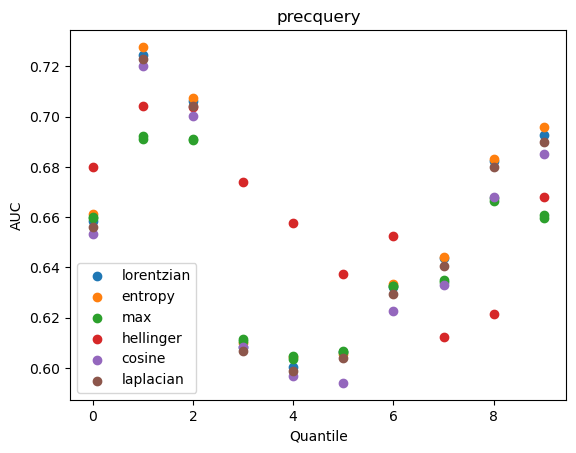

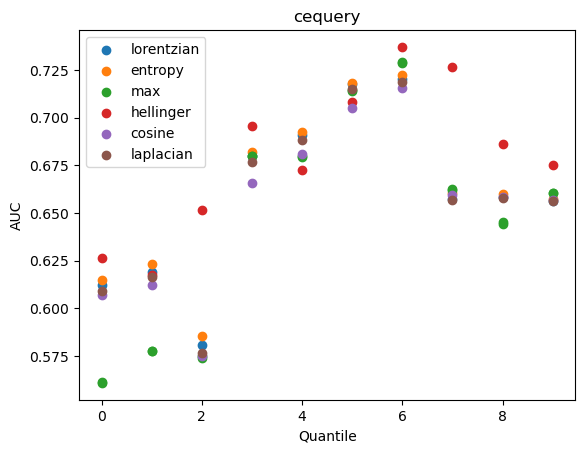

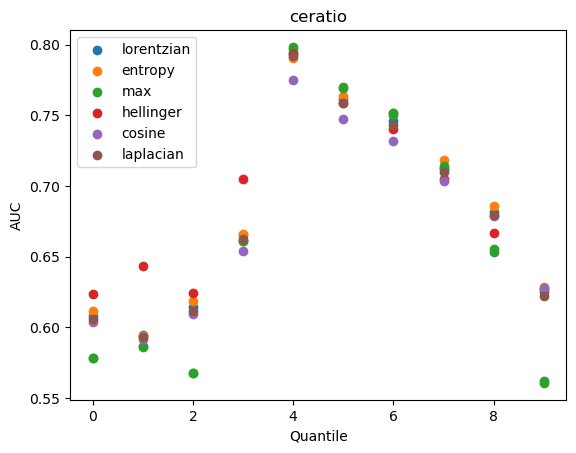

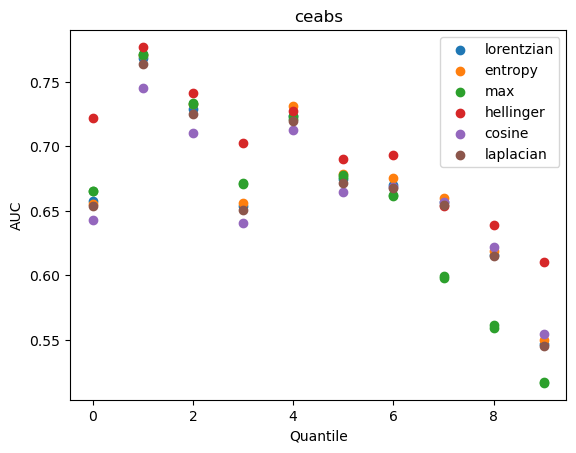

ValueError: Only one class present in y_true. ROC AUC score is not defined in that case.

<Figure size 640x480 with 0 Axes>

In [ ]:
#we will only consider the default weighting scheme here
#consider all the below metrics
reload(plotAndOrderResults)
reload(tests)
metrics=['lorentzian','lorentzian_jonah','entropy','max_entropy','hellinger','max_bhattacharya_2','cosine','laplacian']
quantile_variables = ['precquery', 'cequery','ceratio','ceabs', 'npeaks_query','normalent_query','ent_query','mass_reduction_query']
quantile_num=10


for i in ppm_windows:

    matches = pd.read_pickle(f'{outputs_path}/intermediateOutputs/fullSearchMatches/matches_{i}_ppm.pkl')
    input_data = datasetBuilder.create_model_dataset(matches,
                                                     sim_methods=metrics,
                                                     noise_threshes=[0.01],
                                                     centroid_tolerance_vals=[0.05],
                                                     centroid_tolerance_types=["da"],
                                                     powers=[1])

    metrics = input_data.columns[-len(metrics):-1]
    
    plotAndOrderResults.fig3(input_data, metrics, quantile_variables, quantile_num,f'{outputs_path}/fig3')

Figure 4: Combining Features Into Learned Model

First: Create Train and Test datasets for each ppm window

In [ ]:
#Similarity methods and transformation parameters below. Leave sim methods as None to run all
noise_threshes=[0.01,0.05]
centroid_tolerance_vals = [0.05,0.1]
centroid_tolerance_types=['da','da']
powers=[0.25,1,'orig','normalent']
sim_methods=['lorentzian','lorentzian_jonah','entropy','max_entropy','hellinger','max_bhattacharya_2']


train_size=1e6
val_size=2e5
test_size=5e5

max_matches=None

target_=pd.read_pickle(target)

for i in ppm_windows:

    #read in first bases and shuffle order
    query_train = pd.read_pickle(f'{outputs_path}/intermediateOutputs/splitMatches/first_query.pkl')
    query_train=query_train.sample(frac=1)

    #create matches for model to train on
    matches = datasetBuilder.create_matches_df_new(query_train,target_,i,max_matches,train_size, adduct_match)
    del(query_train)

    train = datasetBuilder.create_model_dataset(
                                                matches, 
                                                sim_methods, 
                                                noise_threshes, 
                                                centroid_tolerance_vals, 
                                                centroid_tolerance_types,
                                                powers
                                                )

    print(len(train))
    
    train.to_pickle(f'{outputs_path}/intermediateOutputs/modelDatasets/train_{i}_ppm.pkl')
    del(matches)
    del(train)

    #read in first bases and shuffle order
    query_val = pd.read_pickle(f'{outputs_path}/intermediateOutputs/splitMatches/second_query.pkl')
    query_val=query_val.sample(frac=1)

    #create matches for model to train on
    matches = datasetBuilder.create_matches_df_new(query_val,target_,i,max_matches,train_size, adduct_match)
    del(query_val)

    val = datasetBuilder.create_model_dataset(
                                                matches, 
                                                sim_methods, 
                                                noise_threshes, 
                                                centroid_tolerance_vals, 
                                                centroid_tolerance_types,
                                                powers
                                                )

    print(len(val))
    
    val.to_pickle(f'{outputs_path}/intermediateOutputs/modelDatasets/val_{i}_ppm.pkl')
    del(matches)
    del(val)

    #read in test queries and shuffle order
    query_test = pd.read_pickle(f'{outputs_path}/intermediateOutputs/splitMatches/third_query.pkl')
    query_test=query_test.sample(frac=1)

    #create matches for model to train on
    matches = datasetBuilder.create_matches_df_new(query_test,target_,i,max_matches,test_size, adduct_match)

    del(query_test)

    test = datasetBuilder.create_model_dataset(
                                                matches, 
                                                sim_methods, 
                                                noise_threshes, 
                                                centroid_tolerance_vals, 
                                                centroid_tolerance_types,
                                                powers
                                                )
    
    test.to_pickle(f'{outputs_path}/intermediateOutputs/modelDatasets/test_{i}_ppm.pkl')
    matches.to_pickle(f'{outputs_path}/intermediateOutputs/modelDatasets/test_{i}_ppm_matches.pkl')
    del(matches)
    del(test)

100186 rows created
200004 rows created
300276 rows created
400015 rows created
500025 rows created
600011 rows created
700007 rows created
800052 rows created
900005 rows created
total number of query spectra considered: 987713
total inchicores seen: 7909
added 10 settings
945272
100026 rows created
total number of query spectra considered: 157220
total inchicores seen: 1319
added 10 settings
150249
100048 rows created
200015 rows created
300069 rows created
400001 rows created
total number of query spectra considered: 472802
total inchicores seen: 3955
added 10 settings


Then, create the indices we want to test (different features for model)

In [ ]:
reload(datasetBuilder)
indices=dict()

noise_threshes=[True,True]
centroid_tolerance_values=[True,True]
powers=[True,True,True,True]
spec_features=[True,True, True, True, True, True, True, True]#8
sim_methods=[True,True,True,True,True, True]#6

indices['all'] = datasetBuilder.generate_keep_indices(noise_threshes,
                                                      centroid_tolerance_values,
                                                      powers,
                                                      spec_features,
                                                      sim_methods,
                                                      True,
                                                      True,
                                                      True
                                                    )

indices['all_but_nonspec'] = datasetBuilder.generate_keep_indices(noise_threshes,
                                                      centroid_tolerance_values,
                                                      powers,
                                                      spec_features,
                                                      sim_methods,
                                                      True,
                                                      False,
                                                      True
                                                    )

indices['nonspec_only']=list(range(9))
indices['nonspec_no_ppm_info']=list(range(2,7))
indices['random_half']=list(np.random.choice(indices['all'][-1], size=int(indices['all'][-1]/2), replace=False))
indices['nonspec_no_precursor']=[2,3,4,5,6]
indices['precursor_only']=[0,1,7,8]


sim_methods=[False for i in range(6)]#7
indices['no_sims'] = datasetBuilder.generate_keep_indices(noise_threshes,
                                                      centroid_tolerance_values,
                                                      powers,
                                                      spec_features,
                                                      sim_methods,
                                                      False,
                                                      True,
                                                      True
                                                    )

noise_threshes=[True,True]
centroid_tolerance_values=[True,True]
powers=[True,True,True,True]
spec_features=[False for i in range(8)]#8
sim_methods=[True for i in range(6)]#7

indices['sims_only'] = datasetBuilder.generate_keep_indices(noise_threshes,
                                                      centroid_tolerance_values,
                                                      powers,
                                                      spec_features,
                                                      sim_methods,
                                                      False,
                                                      False,
                                                      False,
                                                    )


noise_threshes=[True,True]
centroid_tolerance_values=[True,True]
powers=[True,True,False,False]
spec_features=[True for i in range(8)]#8
sim_methods=[True,True,False,False,False, False]#7

indices['small_model'] = datasetBuilder.generate_keep_indices(noise_threshes,
                                                      centroid_tolerance_values,
                                                      powers,
                                                      spec_features,
                                                      sim_methods,
                                                      False,
                                                      True,
                                                      True,
                                                    )

with open(f'{outputs_path}/intermediateOutputs/indices.pkl','wb') as path:
    pickle.dump(indices, path)

del(indices)
    



In [ ]:
reload(plotAndOrderResults)
reload(tests)

with open(f'{outputs_path}/intermediateOutputs/indices.pkl','rb') as path:
    indices = pickle.load(path)

for i in ppm_windows:
        #import train, val and test
        train = pd.read_pickle(f'{outputs_path}/intermediateOutputs/modelDatasets/train_{i}_ppm.pkl')
        val = pd.read_pickle(f'{outputs_path}/intermediateOutputs/modelDatasets/val_{i}_ppm.pkl')
        test = pd.read_pickle(f'{outputs_path}/intermediateOutputs/modelDatasets/test_{i}_ppm.pkl')
        

        #hyperparam specifications for models, 
        #we will choose the best performer on val data for each feature subset
        models = [
                hgbc(),
                hgbc(learning_rate=0.01),
                hgbc(learning_rate=0.5),
                hgbc(max_iter=200),
                hgbc(learning_rate=0.01, max_iter=200),
                hgbc(learning_rate=0.5, max_iter=200),
                hgbc(min_samples_leaf=10),
                hgbc(learning_rate=0.01,min_samples_leaf=10),
                hgbc(learning_rate=0.5,min_samples_leaf=10),
                hgbc(max_iter=200,min_samples_leaf=10),
                hgbc(learning_rate=0.01, max_iter=200,min_samples_leaf=10),
                hgbc(learning_rate=0.5, max_iter=200,min_samples_leaf=10),
                ]

        results_by_subset = tests.best_models_by_subset(indices, [int(1.1e6)], models, train, val, test)

        del(train)
        del(val)
        del(test)

        with open(f'{outputs_path}/intermediateOutputs/models/res_dict_{i}.pkl', 'wb') as models:

                pickle.dump(results_by_subset, models)

        del (results_by_subset)

finished all for 1100000
finished all_but_nonspec for 1100000
finished nonspec_only for 1100000
finished nonspec_no_ppm_info for 1100000
finished random_half for 1100000
finished nonspec_no_precursor for 1100000
finished no_sims for 1100000
finished sims_only for 1100000
finished small_model for 1100000


Fig 4: Plot ROC Curves by Feature Subsets

AUROC by Feature Subset for 10 ppm:
all: Validation: 0.87 Test: 0.87
small_model: Validation: 0.87 Test: 0.86
random_half: Validation: 0.87 Test: 0.86
all_but_nonspec: Validation: 0.8 Test: 0.79
sims_only: Validation: 0.78 Test: 0.77
no_sims: Validation: 0.74 Test: 0.76
nonspec_only: Validation: 0.74 Test: 0.74
nonspec_no_precursor: Validation: 0.54 Test: 0.56
nonspec_no_ppm_info: Validation: 0.54 Test: 0.56


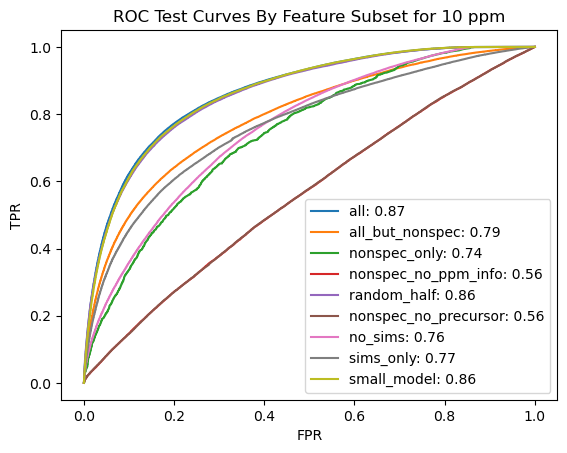

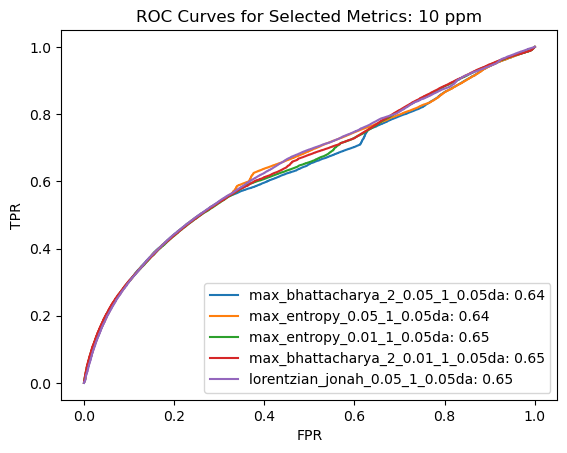

In [ ]:
reload(plotAndOrderResults)
reload(tests)

top_n_metrics=5
ppm_windows=[10]

for i in ppm_windows:

    test=pd.read_pickle(f'{outputs_path}/intermediateOutputs/modelDatasets/test_{i}_ppm.pkl')

    with open(f'{outputs_path}/intermediateOutputs/models/res_dict_{i}.pkl','rb') as path:
        res_dict = pickle.load(path)

    with open(f'{outputs_path}/intermediateOutputs/indices.pkl','rb') as path:
        indices = pickle.load(path)

    plotAndOrderResults.fig4(test, res_dict, indices, f'{outputs_path}/fig4/a', i)
    plotAndOrderResults.fig4b(test, indices['sims_only'], f'{outputs_path}/fig4/b', i, top_n_metrics)    

Fig 5: Compare Performance on a Different Query Database

100026 rows created
200158 rows created
300046 rows created
400042 rows created
500072 rows created
600034 rows created
700013 rows created
800052 rows created
added 10 settings
AUROC by Feature Subset for 10 ppm:
small_model: Validation: 0.87 Test: 0.89
random_half: Validation: 0.87 Test: 0.89
all: Validation: 0.87 Test: 0.89
no_sims: Validation: 0.74 Test: 0.82
all_but_nonspec: Validation: 0.8 Test: 0.81
sims_only: Validation: 0.78 Test: 0.78
nonspec_only: Validation: 0.74 Test: 0.78
nonspec_no_precursor: Validation: 0.54 Test: 0.56
nonspec_no_ppm_info: Validation: 0.54 Test: 0.56


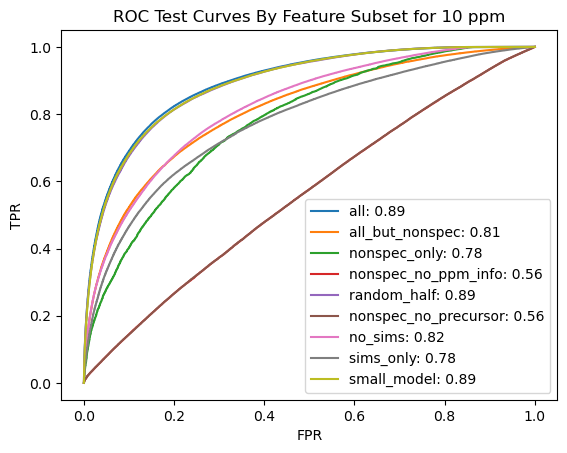

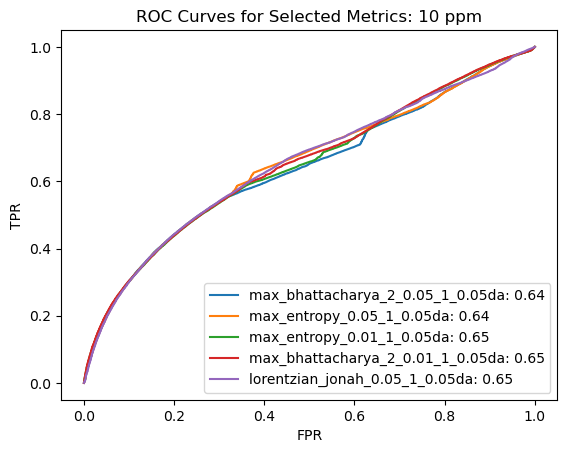

In [ ]:
#set new query database
reload(plotAndOrderResults)
reload(tests)
reload(datasetBuilder)

noise_threshes=[0.01,0.05]
centroid_tolerance_vals = [0.05,0.1]
centroid_tolerance_types=['da','da']
powers=[0.25,1,'orig','normalent']
sim_methods=['lorentzian','lorentzian_jonah','entropy','max_entropy','hellinger','max_bhattacharya_2']


new_query = gnps

size=8e5
max_matches=None
adduct_match=False
top_n_metrics=5

for i in ppm_windows:
    
    new_query_ = pd.read_pickle(new_query)
    new_query_ = new_query_.sample(frac=1)
    target_ = pd.read_pickle(target)

    new_matches = datasetBuilder.create_matches_df_new(new_query_, target_,i ,max_matches,size,adduct_match)
    
    new_matches.to_pickle(f'{outputs_path}/fig5/matches_{i}_ppm.pkl')

    new_dataset = datasetBuilder.create_model_dataset(new_matches, 
                                                      sim_methods, 
                                                      noise_threshes, 
                                                      centroid_tolerance_vals, 
                                                      centroid_tolerance_types,
                                                      powers)
    
    with open(f'{outputs_path}/intermediateOutputs/indices.pkl','rb') as path:
        indices = pickle.load(path)
        
    with open(f'{outputs_path}/intermediateOutputs/models/res_dict_{i}.pkl','rb') as path:
        res_dict = pickle.load(path)

    plotAndOrderResults.fig5(new_dataset, res_dict, indices, f'{outputs_path}/fig5/a', i)
    plotAndOrderResults.fig4b(new_dataset, indices['sims_only'], f'{outputs_path}/fig5/b', i, top_n_metrics) 

    #look at all individual metric ROCS
    individual_metrics=dict()
    for i in indices['sims_only']:

        individual_metrics[new_dataset.columns[i]]=list([i])

Other Ideas:

Accuracy (In order of increasing difficulty):

-Incorporate as feature how many possible chem structures (can also restrict to NPS) exist within a certain precursor distance. (violating golden rules or not)

-include original NIST version or theoretical res as feature

-Weight different ranges of spec differently for matches (more diversity/greater accuracy)

-smush together top n results over different inchicores and come up with combined model predicting over individual inchicores

-diagnostic ion/loss classing as a feature...do they match

-kernelized smooth match

-3d struct guesses...do they match (cores, but can generalize to 3d)

Speed(In order of increasing difficulty):

-combine sim metrics and expand(apply func to df)

-exclude matches based on non-similarity features to cut down on needed comparisons

-ion tables to upper bound similarity

-only use one peak consolidation and matching protocol...then only do reweight transformations on already matched peaks for spec and sim features

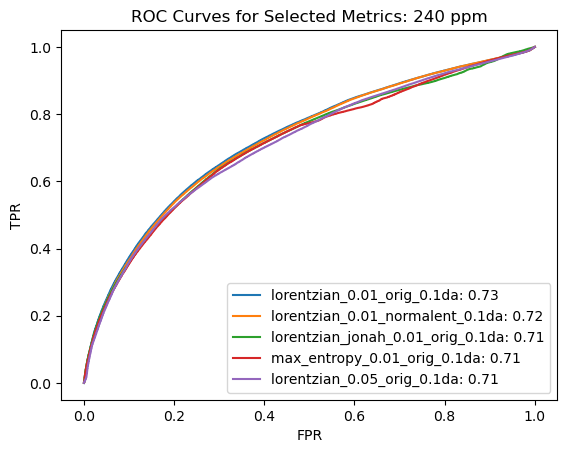

In [ ]:
reload(plotAndOrderResults)
plotAndOrderResults.fig4b(new_dataset, indices['sims_only'], f'{outputs_path}/fig5/b', i, top_n_metrics)